# Bibliotecas Usadas

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Análise Exploratória

In [4]:
df_labels = pd.read_csv('./stratified_sample.csv')
df_labels.head()

,exam_id,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,1165429,exams_part3.hdf5,False,False,False,False,True,False
1,1492927,exams_part4.hdf5,True,False,False,False,False,False
2,808962,exams_part2.hdf5,False,False,False,False,True,False
3,4270131,exams_part7.hdf5,False,False,False,False,True,False
4,1199155,exams_part12.hdf5,False,False,False,False,False,True


In [5]:
df_data = pd.read_csv('./features_grafos.csv')
df_data.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


In [6]:
df_data.describe()

,exam_id,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
count,4.395000e+03,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4.395000e+03,4395.000000,4395.0,...,4.395000e+03,4.395000e+03,4395.000000,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4395.000000,4395.000000
mean,1.035330e+06,146310.026394,0.008723,35.720221,0.008723,0.252987,0.001362,2.441406e-04,0.632448,0.0,...,2.811792e+05,1.862319e+05,86.636405,1.361529e+05,1.507215e+05,1.214594e+05,1.206377e+05,4.520451e+04,36009.499886,3293.378840
std,3.379288e+05,49890.684535,0.002974,12.180343,0.002974,0.028766,0.000494,5.000028e-17,0.044218,0.0,...,2.873890e+05,1.622984e+05,198.545559,1.773939e+05,1.811744e+05,1.293498e+05,1.483680e+05,7.126054e+04,46906.018121,2851.095231
min,1.000000e+02,45140.000000,0.002691,11.020508,0.002691,0.165578,0.000241,2.441406e-04,0.256882,0.0,...,2.025000e+03,5.049000e+03,0.000000,8.520000e+02,1.354000e+03,2.726000e+03,2.475000e+03,1.590000e+02,295.000000,89.000000
25%,1.049923e+06,111234.000000,0.006632,27.156738,0.006632,0.233850,0.001034,2.441406e-04,0.607870,0.0,...,9.414950e+04,7.138850e+04,20.000000,4.339500e+04,4.431600e+04,4.671250e+04,3.718900e+04,9.823500e+03,9573.000000,1611.500000
50%,1.133758e+06,136090.000000,0.008114,33.225098,0.008114,0.252350,0.001298,2.441406e-04,0.637108,0.0,...,1.940400e+05,1.395740e+05,46.000000,8.103100e+04,9.159500e+04,8.218700e+04,7.271600e+04,2.131200e+04,19620.000000,2504.000000
75%,1.214330e+06,171752.000000,0.010240,41.931641,0.010240,0.271683,0.001629,2.441406e-04,0.661601,0.0,...,3.690130e+05,2.524635e+05,95.000000,1.629360e+05,1.830110e+05,1.489815e+05,1.432230e+05,5.188500e+04,43251.000000,4070.000000
max,1.299861e+06,638204.000000,0.038049,155.811523,0.038049,0.457899,0.005069,2.441406e-04,0.887047,0.0,...,4.332758e+06,2.078639e+06,5535.000000,4.765979e+06,2.420806e+06,2.671640e+06,2.234852e+06,1.600920e+06,748421.000000,49965.000000


In [7]:
merged_df = pd.merge(df_data, df_labels, on='exam_id')
merged_df.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_31,motif_5_32,motif_5_33,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,1225,1326,420,exams_part9.hdf5,True,False,False,False,False,True
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,21541,23556,2860,exams_part3.hdf5,False,True,True,False,False,False
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,62617,44203,6128,exams_part14.hdf5,False,False,False,True,False,False
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,31149,22833,3323,exams_part0.hdf5,True,False,False,False,False,False
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,149396,180611,9639,exams_part6.hdf5,False,False,False,False,False,False


In [8]:
X = merged_df.drop(columns=['exam_id', 'lead', 'trace_file', 'SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB'])
y = merged_df[ ['SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB']]

In [9]:
X.head()

,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,motif_3_1,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,0,0,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,0,0,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,0,0,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,0,0,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,0,0,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


In [10]:
X.columns

Index(['num_edges', 'density', 'avg_node_degree', 'avg_degree_centrality',
       'avg_closeness_centrality', 'avg_curr_flow_closeness_centrality',
       'avg_pagerank', 'avg_clustering_coef', 'motif_3_0', 'motif_3_1',
       'motif_3_2', 'motif_3_3', 'motif_4_0', 'motif_4_1', 'motif_4_2',
       'motif_4_3', 'motif_4_4', 'motif_4_5', 'motif_4_6', 'motif_4_7',
       'motif_4_8', 'motif_4_9', 'motif_4_10', 'motif_5_0', 'motif_5_1',
       'motif_5_2', 'motif_5_3', 'motif_5_4', 'motif_5_5', 'motif_5_6',
       'motif_5_7', 'motif_5_8', 'motif_5_9', 'motif_5_10', 'motif_5_11',
       'motif_5_12', 'motif_5_13', 'motif_5_14', 'motif_5_15', 'motif_5_16',
       'motif_5_17', 'motif_5_18', 'motif_5_19', 'motif_5_20', 'motif_5_21',
       'motif_5_22', 'motif_5_23', 'motif_5_24', 'motif_5_25', 'motif_5_26',
       'motif_5_27', 'motif_5_28', 'motif_5_29', 'motif_5_30', 'motif_5_31',
       'motif_5_32', 'motif_5_33'],
      dtype='object')

In [11]:
y.head()

,SB,1dAVb,LBBB,ST,AF,RBBB
0,True,False,False,False,False,True
1,False,True,True,False,False,False
2,False,False,False,True,False,False
3,True,False,False,False,False,False
4,False,False,False,False,False,False


In [12]:
for c in y.columns:
    print(f"{c}: {y[c].sum()}")
num_rows_all_false = (y.sum(axis=1) == 0).sum()
print(f"saudavel : {num_rows_all_false}")

SB: 691
1dAVb: 658
LBBB: 736
ST: 711
AF: 651
RBBB: 682
saudavel : 752


# Modelagem

## Multiclass Classification

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
classifier = MultiOutputClassifier(RandomForestClassifier())

In [15]:
classifier.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier())

In [16]:
y_pred = classifier.predict(X_test)

# Validação

In [17]:
def print_metrics(y_test, y_pred):
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming_loss_value = hamming_loss(y_test, y_pred)
    jaccard_similarity = jaccard_score(y_test, y_pred, average='samples')
    print(f"precision micro: {precision_micro}")
    print(f"recall micro: {recall_micro}")
    print(f"f1 micro: {f1_micro}")
    print(f"precision macro: {precision_macro}")
    print(f"recall macro: {recall_macro}")
    print(f"f1 macro = {f1_macro}")
    print(f"hamming loss_value: {hamming_loss_value}")
    print(f"jaccard similary: {jaccard_similarity}")

In [18]:
print_metrics(y_test, y_pred)

precision micro: 0.7767584097859327
recall micro: 0.3175
f1 micro: 0.45075421472937
precision macro: 0.6242938552607542
recall macro: 0.30246748385434524
f1 macro = 0.3731438237180538
hamming loss_value: 0.1173682214637846
jaccard similary: 0.2697193780811528


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the OneVsRestClassifier with Logistic Regression as the base classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Train the model
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)
print_metrics(y_test, y_pred)

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

precision micro: 0.684
recall micro: 0.21375
f1 micro: 0.3257142857142857
precision macro: 0.5233436313058364
recall macro: 0.20346648485334617
f1 macro = 0.27217022636355415
hamming loss_value: 0.1342434584755404
jaccard similary: 0.17832764505119453


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_true_binary = np.array(y_test, dtype=int)
y_pred_binary = np.array(y_pred, dtype=int)
conf_matrix = multilabel_confusion_matrix(y_true_binary, y_pred_binary)

Confusion Matrix for Label 'SB':
[[717  22]
 [100  40]]


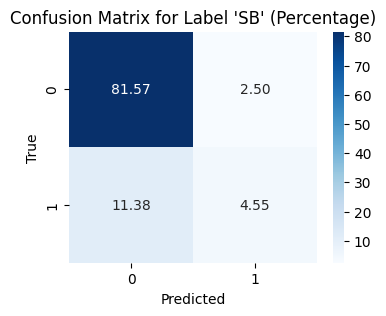

Confusion Matrix for Label '1dAVb':
[[761   8]
 [109   1]]


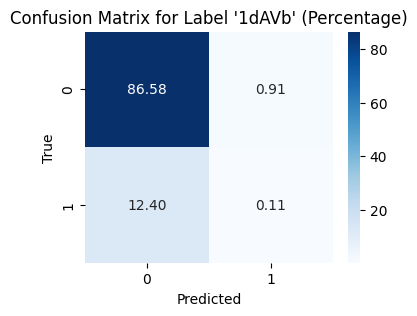

Confusion Matrix for Label 'LBBB':
[[723  16]
 [ 66  74]]


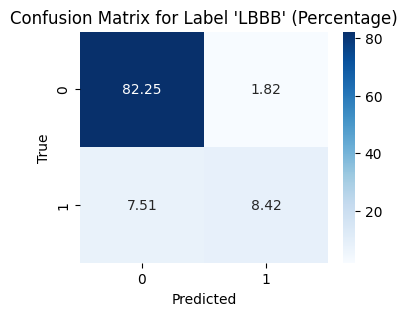

Confusion Matrix for Label 'ST':
[[715  21]
 [ 97  46]]


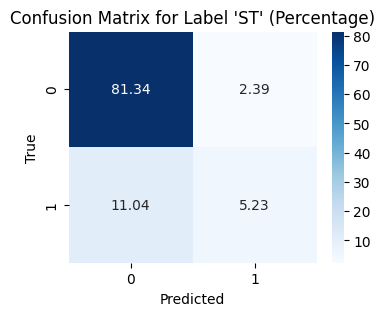

Confusion Matrix for Label 'AF':
[[737   5]
 [134   3]]


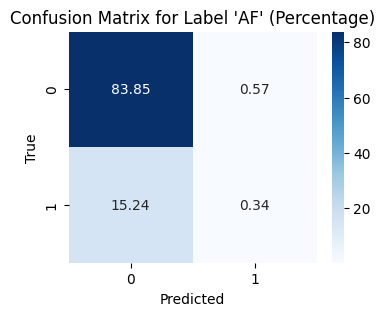

Confusion Matrix for Label 'RBBB':
[[742   7]
 [123   7]]


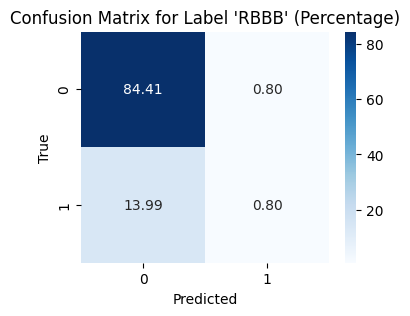

In [21]:
label_names = y.columns

for i, label_conf_matrix in enumerate(conf_matrix):
    label_name = label_names[i]
    
    print(f"Confusion Matrix for Label '{label_name}':")
    print(label_conf_matrix)

    # Convert to percentages
    total_instances = label_conf_matrix.sum()
    percentage_conf_matrix = (label_conf_matrix / total_instances) * 100

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(percentage_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix for Label '{label_name}' (Percentage)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [22]:
from skmultilearn.model_selection import IterativeStratification
kf = IterativeStratification(n_splits=5)
metrics_array = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train your model (replace RandomForestClassifier with your model)
    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Evaluate the model (replace accuracy_score with your evaluation metric)
    f1 = f1_score(y_test, y_pred, average='micro')
    print("f1:", f1)
    metrics_array.append(f1)
print(f"f1: {np.mean(metrics_array):.3f} +- {np.std(metrics_array):.3f}")


f1: 0.3866305329719964
f1: 0.38348623853211006
f1: 0.41990950226244345
f1: 0.43046944198405673
f1: 0.39490445859872614
f1: 0.403 +- 0.019


# One class classification

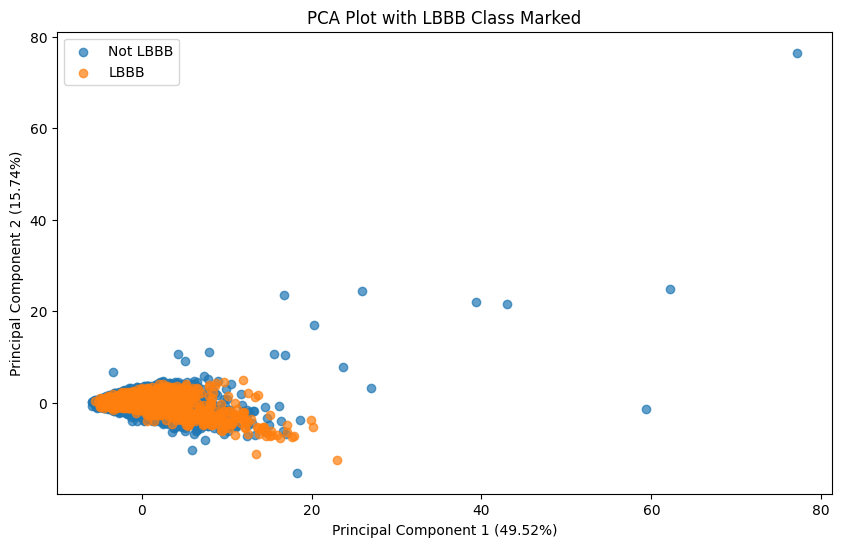

In [32]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Create a DataFrame with PCA components and target variable
pca_df = pd.DataFrame(data={'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'LBBB': y['LBBB']})

# Plot the points
plt.figure(figsize=(10, 6))

# Plot points not belonging to LBBB class
plt.scatter(pca_df.loc[pca_df['LBBB'] == False, 'PCA1'], pca_df.loc[pca_df['LBBB'] == False, 'PCA2'], label='Not LBBB', alpha=0.7)

# Plot points belonging to LBBB class
plt.scatter(pca_df.loc[pca_df['LBBB'] == True, 'PCA1'], pca_df.loc[pca_df['LBBB'] == True, 'PCA2'], label='LBBB', alpha=0.7)

# Set labels and title
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA Plot with LBBB Class Marked')

# Show legend
plt.legend()

# Show the plot
plt.show()

## SVM

f1: 0.910
              precision    recall  f1-score   support

          -1       0.33      0.04      0.06       140
           1       0.84      0.99      0.91       739

    accuracy                           0.84       879
   macro avg       0.59      0.51      0.49       879
weighted avg       0.76      0.84      0.77       879



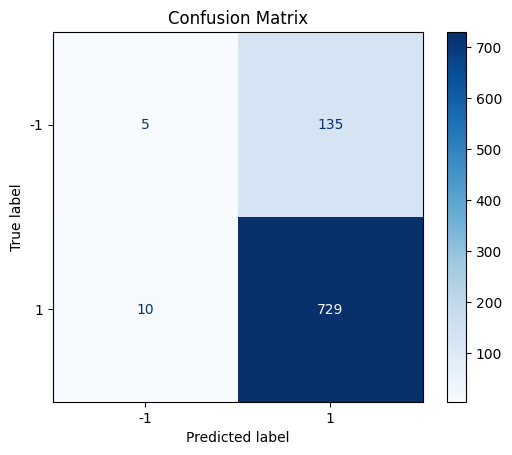

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(gamma='scale', nu=0.01)
# Selecionando só as amostras negativas
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

(3516, 57)
(596, 57)
f1: 0.280
              precision    recall  f1-score   support

          -1       0.93      0.05      0.10       739
           1       0.16      0.98      0.28       140

    accuracy                           0.20       879
   macro avg       0.55      0.52      0.19       879
weighted avg       0.81      0.20      0.13       879



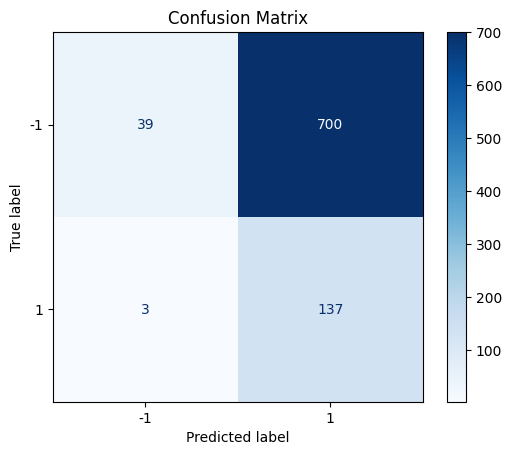

In [62]:
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(gamma='scale', nu=0.01)
# Selecionando só as amostras positivas
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = 1
y_test_one_class[y_test_one_class == 0] = -1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

## Isolation Forest

f1: 0.912
              precision    recall  f1-score   support

          -1       0.45      0.04      0.07       140
           1       0.84      0.99      0.91       739

    accuracy                           0.84       879
   macro avg       0.65      0.51      0.49       879
weighted avg       0.78      0.84      0.78       879



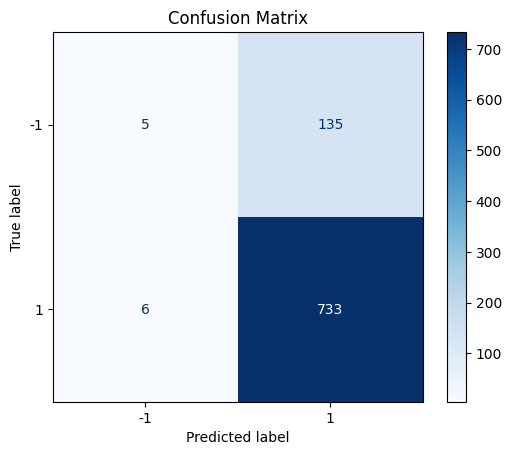

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

f1: 0.264
              precision    recall  f1-score   support

          -1       0.46      0.01      0.02       739
           1       0.15      0.95      0.26       140

    accuracy                           0.16       879
   macro avg       0.31      0.48      0.14       879
weighted avg       0.41      0.16      0.06       879



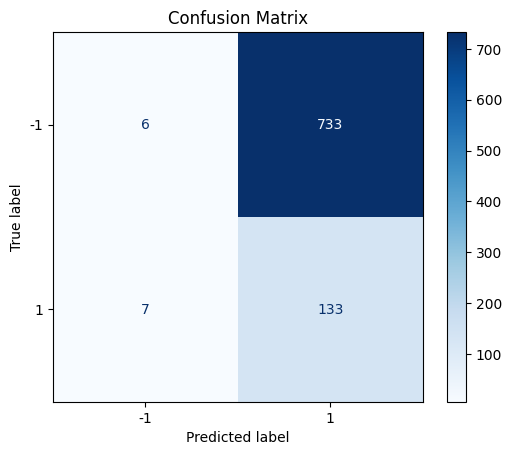

In [73]:
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(contamination=0.01)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = 1
y_test_one_class[y_test_one_class == 0] = -1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

## Minimum Covariance Determinant

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.907
              precision    recall  f1-score   support

          -1       0.09      0.01      0.01       140
           1       0.84      0.99      0.91       739

    accuracy                           0.83       879
   macro avg       0.47      0.50      0.46       879
weighted avg       0.72      0.83      0.76       879



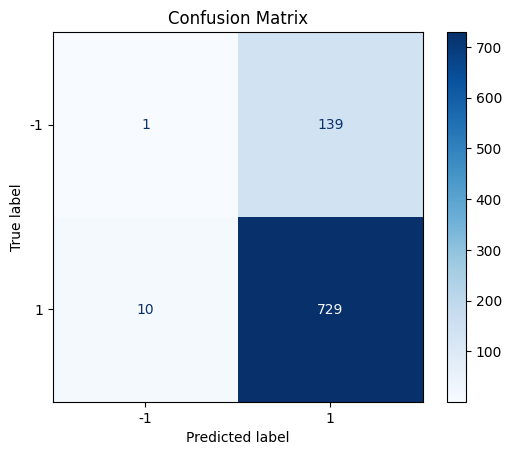

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.277
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       739
           1       0.16      1.00      0.28       140

    accuracy                           0.17       879
   macro avg       0.58      0.50      0.15       879
weighted avg       0.87      0.17      0.06       879



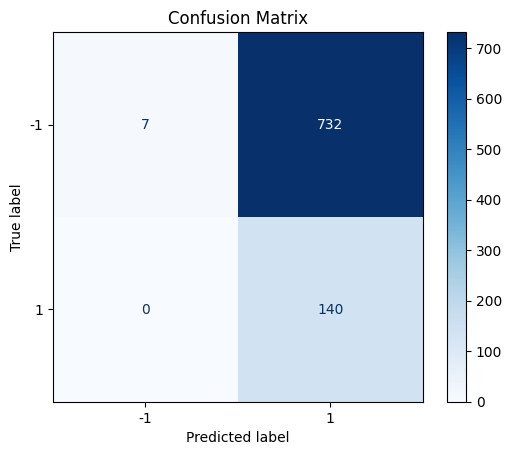

In [74]:
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.01)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = 1
y_test_one_class[y_test_one_class == 0] = -1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

## Local Outlier Factor

f1: 0.908
              precision    recall  f1-score   support

          -1       0.23      0.02      0.04       140
           1       0.84      0.99      0.91       739

    accuracy                           0.83       879
   macro avg       0.54      0.50      0.47       879
weighted avg       0.74      0.83      0.77       879



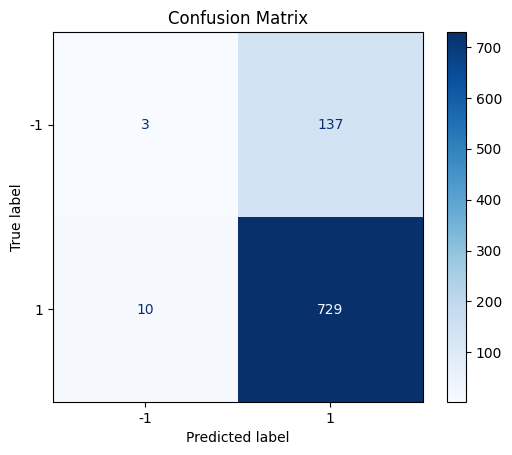

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

def lot_predict(one_class_classifier, X_train_one_class, X_test_one_class):
    # create one large dataset
    composite = np.vstack((X_train_one_class, X_test_one_class))
    # make prediction on composite dataset
    y_pred_one_class = one_class_classifier.fit_predict(composite)
    # return just the predictions on the test set
    return y_pred_one_class[len(X_train_one_class):]

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

f1: 0.272
              precision    recall  f1-score   support

          -1       0.77      0.01      0.03       739
           1       0.16      0.98      0.27       140

    accuracy                           0.17       879
   macro avg       0.46      0.50      0.15       879
weighted avg       0.67      0.17      0.07       879



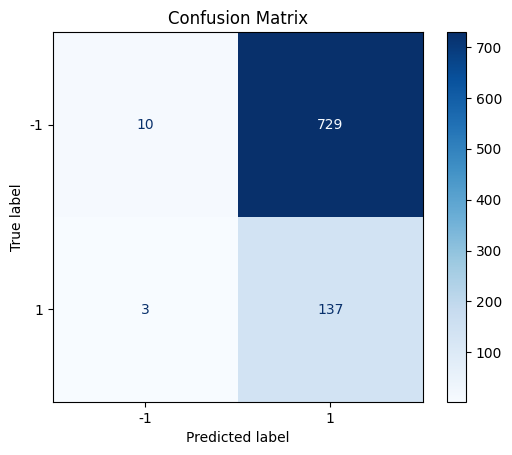

In [79]:
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 1] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = 1
y_test_one_class[y_test_one_class == 0] = -1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()